## Validate vs Ember

In [17]:
"""Boiler plate
- import all packages
- emulate snakemake so can load config as usual
- load the network you want
TODO: make it easier to restore old runs
TODO: hide all the boiler pates in a file
"""
%load_ext autoreload
%autoreload 2
%precision %e

import itertools
import logging
import os.path

# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import requests

working_directory = os.path.dirname(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
)
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)


logging.basicConfig(level=logging.CRITICAL)
logger = logging.getLogger(__name__)


# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake

logging.getLogger("plot_network").setLevel(logging.CRITICAL)
logging.getLogger("_plot_utilities").setLevel(logging.CRITICAL)

from _plot_utilities import determine_plottable, fix_network_names_colors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import yaml

REMIND_COUPLED = False
PLANNING_YEAR = 2020
config = None if not REMIND_COUPLED else "resources/tmp/remind_coupled.yaml"
# config = None if not REMIND_COUPLED else "resources/tmp/tmp.yaml"

if config is not None:
    with open(os.path.join(root_dir, config)) as f:
        yaml_config = yaml.safe_load(f)
    co2_pathway = yaml_config["scenario"]["co2_pathway"][0]
else:
    co2_pathway="exp175default"

snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=workflow_dir,
    topology="current+FCG",
    co2_pathway=co2_pathway,
    planning_horizons=PLANNING_YEAR,
    configfiles=config,
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network
print(f"Loading network from {ntw_path}")
n = pypsa.Network(ntw_path)
results_dir = os.path.dirname(os.path.dirname(ntw_path))
weighting = n.snapshot_weightings.iloc[0, 0]


fix_network_names_colors(n, config)
determine_plottable(n);

2025-09-02 11:52:42,145 - _helpers.py - INFO - =========== NEW RUN ===========
INFO:__main__:=========== NEW RUN ===========


Loading network from /p/tmp/ivanra/PyPSA-China-clone/PyPSA-China-PIK/results/v-1.1.1_heat_couple_test_chp_brown_real_demand_jingji_link/overnight_co2pw-exp175default_topo-current+FCG_proj-positive/postnetworks/ntwk_2020.nc


/p/tmp/ivanra/PyPSA-China-clone/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:285: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# get Ember

In [19]:
with open("../../resources/apikeys/ember.txt") as f:
    my_api_key = f.read()
base_url = "https://api.ember-energy.org"
query_url = (
    f"{base_url}/v1/electricity-generation/yearly"
    + f"?entity_code=CHN&is_aggregate_series=false&start_date=2015&api_key={my_api_key}"
)
response = requests.get(query_url)
if response.status_code == 200:
    data = response.json()


ember_data = pd.DataFrame.from_records(data["data"])
year = str(min(2024, int(PLANNING_YEAR)))
ember_yr = ember_data.query("date==@year").set_index("series")
ember_yr.index = ember_yr.index.str.lower()
ember_yr.rename({"bioenergy": "biomass", "hydro": "hydroelectricity"}, inplace=True)

len_ = ember_yr.shape[0]
ember_yr = ember_yr.loc[
    [
        "coal",
        "biomass",
        "gas",
        "other fossil",
        "wind",
        "solar",
        "nuclear",
        "hydroelectricity",
        "net imports",
    ]
]
assert len_ == ember_yr.shape[0], (
    "The order of the rows has changed, please check the code"
)

In [20]:
# Use a sequence of default matplotlib colors for the pie chart
colors_ember = ember_yr.rename({"wind": "onwind"}).index.map(n.carriers.color).to_list()
default_colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])
for i, c in enumerate(colors_ember):
    if pd.isna(c):
        colors_ember[i] = next(default_colors)
labels_ember = [
    f"{idx} ({val:.1f}%)" for idx, val in ember_yr.share_of_generation_pct.items()
]

In [21]:
eb = n.statistics.supply(
    groupby=pypsa.statistics.get_carrier_and_bus_carrier, comps=["Generator", "Link"]
)
ac_balance = eb.reset_index().query("bus_carrier == 'AC'").groupby("carrier").sum()
ac_balance.rename(columns={0: "AC supply"}, inplace=True)
ac_balance = ac_balance[ac_balance["AC supply"] > 0]["AC supply"]
if "battery discharger" in ac_balance.index:
    ac_balance.drop("battery discharger", inplace=True)

# group gas and coal
ac_balance_mod = ac_balance.copy()
gas_sum = ac_balance_mod.get("Open-Cycle Gas", 0) + ac_balance_mod.get(
    "Combined-Cycle Gas", 0
) + ac_balance_mod.get(
    "CHP Gas", 0
)
ac_balance_mod = ac_balance_mod.drop(
    ["Open-Cycle Gas", "Combined-Cycle Gas"], errors="ignore"
)
ac_balance_mod.loc["Gas"] = gas_sum

coal_sum = ac_balance_mod.get("CHP coal", 0) + ac_balance_mod.get(
    "Coal Power Plant", 0
) 
ac_balance_mod = ac_balance_mod.drop(
    ["CHP coal", "Coal Power Plant"], errors="ignore"
)
ac_balance_mod.loc["Coal"] = coal_sum

# Calculate percentage labels
total = ac_balance_mod.sum()
# Drop entries with less than 0.1%
ac_balance_mod = ac_balance_mod[ac_balance_mod / total >= 0.001]
if (total - ac_balance_mod.sum()) / total >= 0.001:
    ac_balance_mod.loc["Other"] = total - ac_balance_mod.sum()

plot_list = [
    "coal",
    "biomass",
    "Gas",
    "Coal",
    "Onshore Wind",
    "Offshore Wind",
    "Solar",
    "nuclear",
    "Hydroelectricity",
    "CHP coal",
    "CHP gas",
    "Other",
]
missing = set(plot_list) - set(ac_balance_mod.index)
if missing:
    print(f"Warning: The following entries are missing from the balance: {missing}")
mask = ac_balance_mod.index.isin(plot_list)
ac_balance_mod = ac_balance_mod.loc[[c for c in plot_list if c in ac_balance_mod.index]]
n.carriers.loc["coal", "nice_name"] = "Coal"
colors = ac_balance_mod.index.map(n.carriers.set_index("nice_name").color)
colors = colors.fillna("lightgrey")  # Fill NaN colors with light grey
total = ac_balance_mod.sum()
labels = [
    f"{idx.replace('Power Plant', '')} ({val / total:.1%})"
    for idx, val in ac_balance_mod.items()
]

ac_balance_mod.name = ""

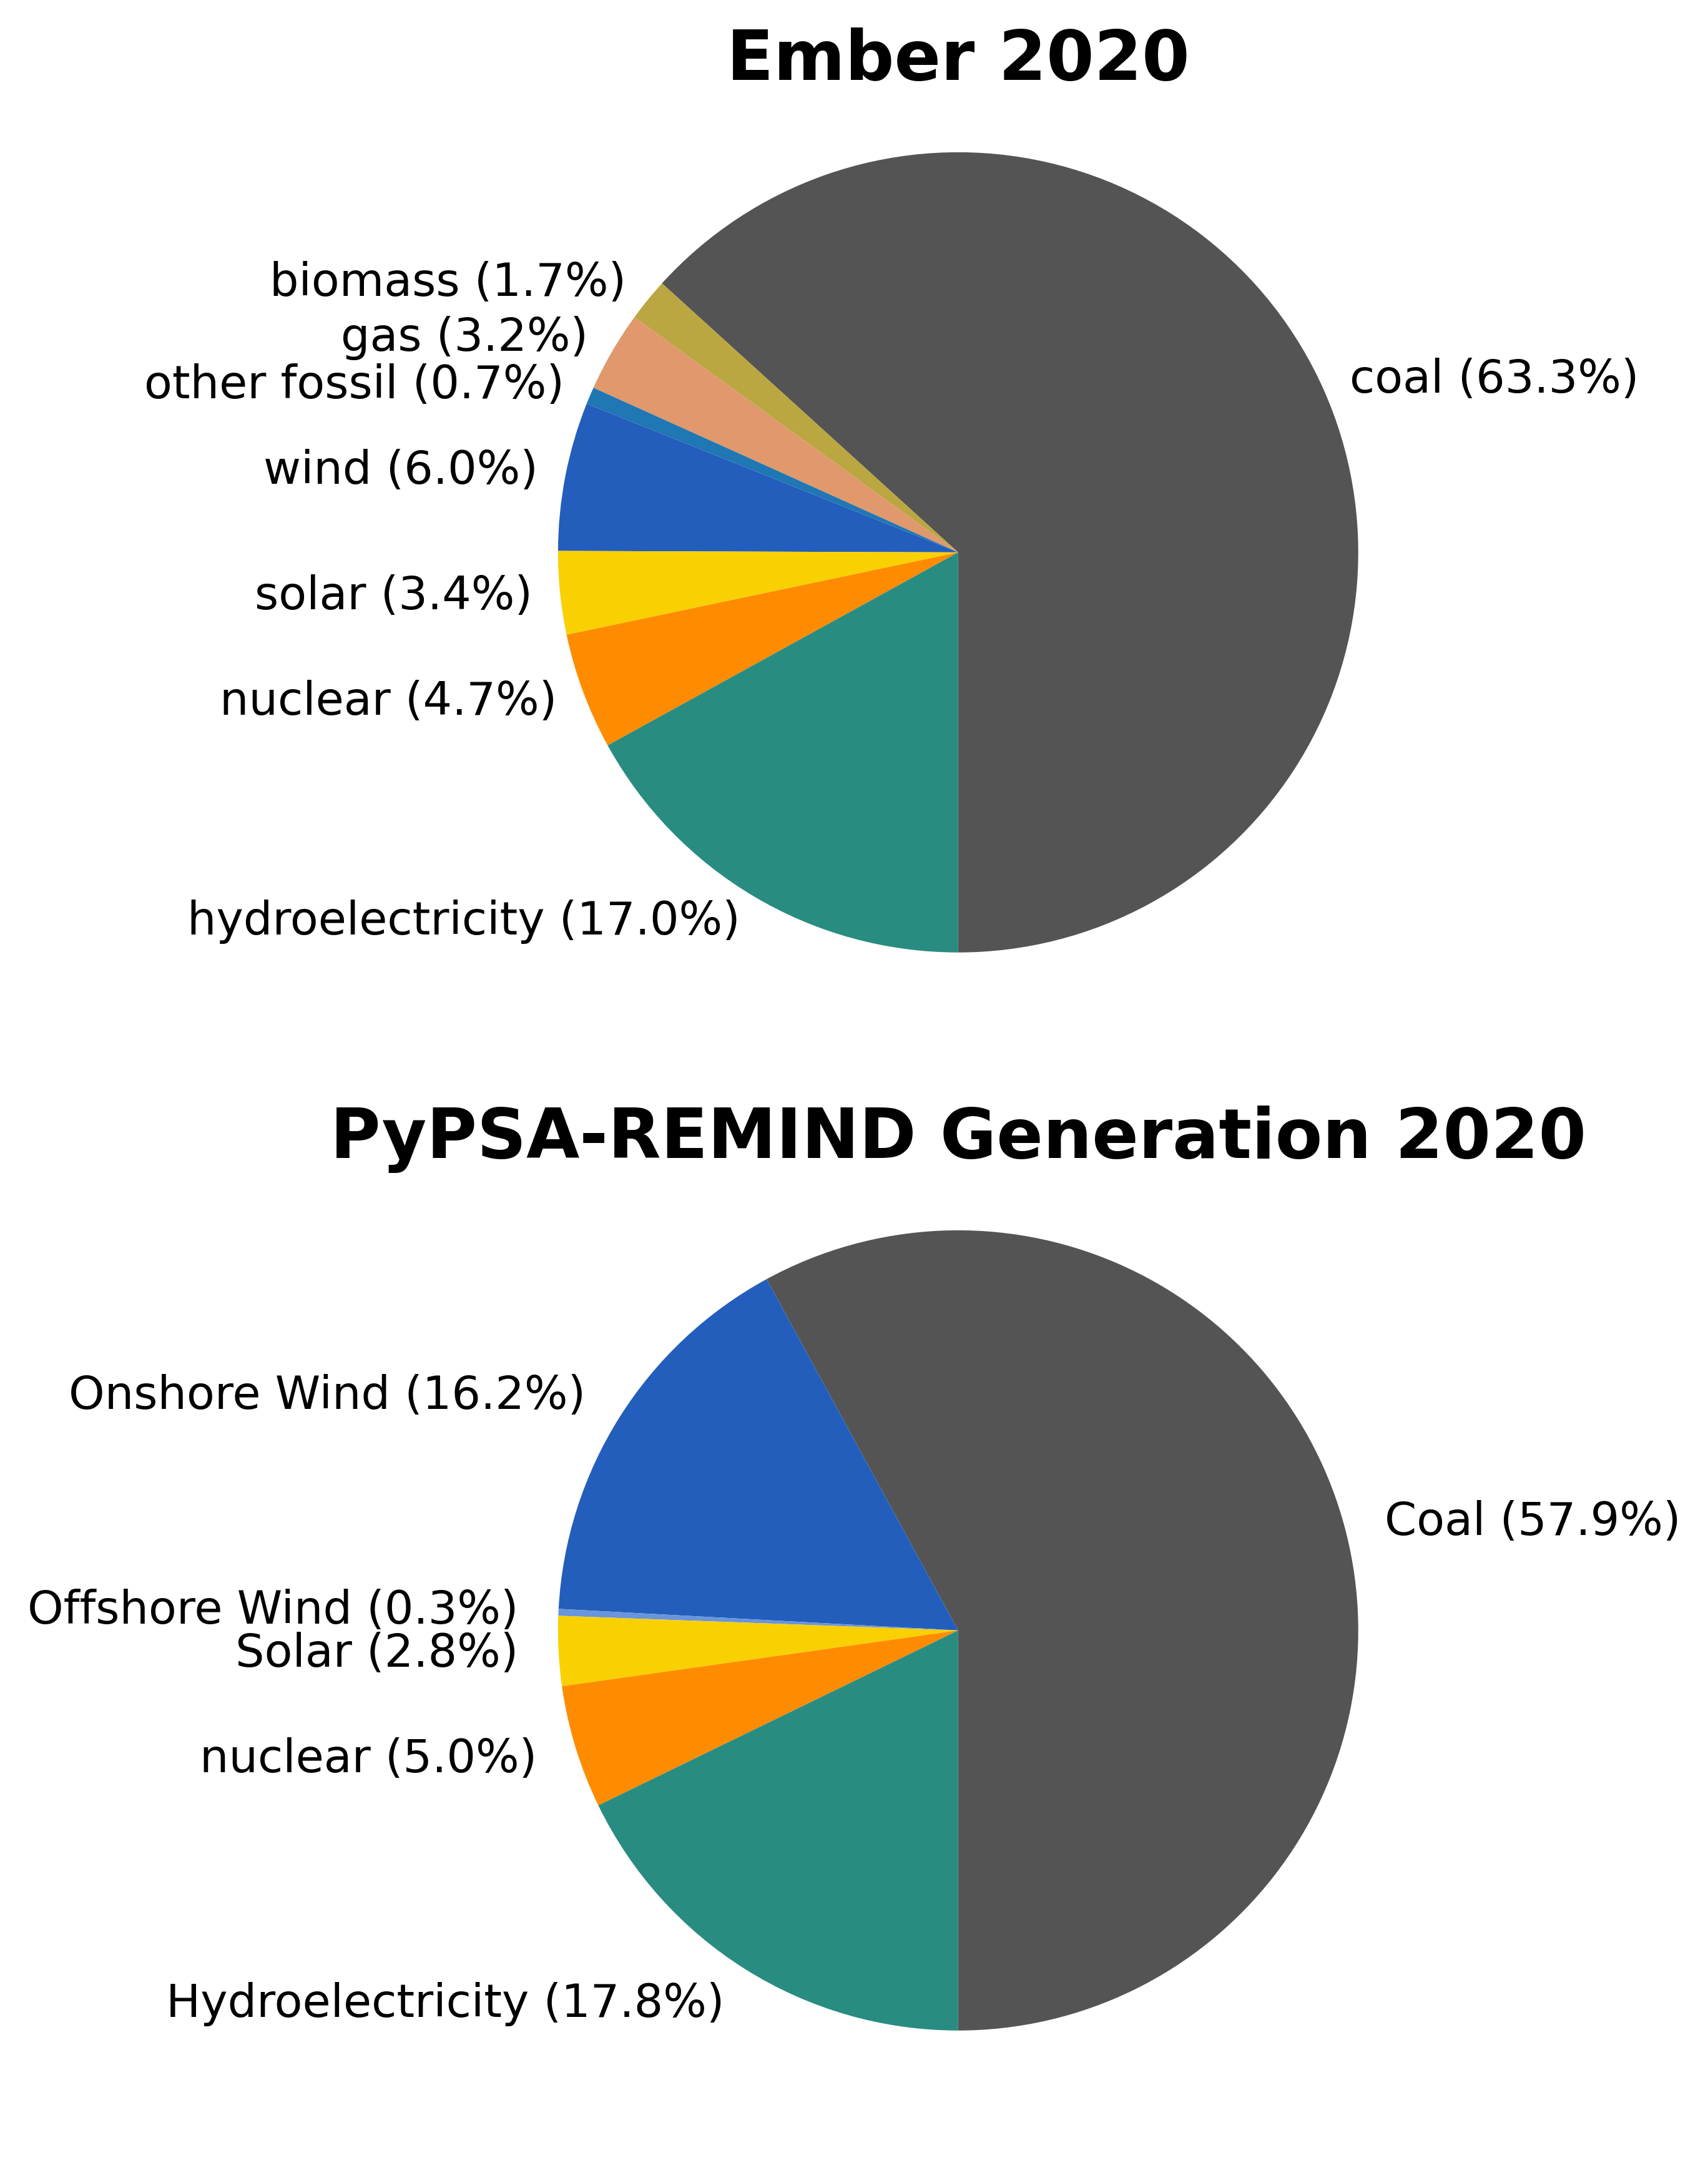

In [22]:
fig, axes = plt.subplots(
    2,
    1,
    figsize=(20, 8),
)
ember_yr.share_of_generation_pct.clip(0).plot.pie(
    colors=colors_ember,
    labels=labels_ember,
    textprops={"fontsize": 12},
    legend=False,
    labeldistance=1.07,  # Move labels outward to reduce overlap
    startangle=270,
    ax=axes[0],
)
axes[0].set_title(
    f"Ember {PLANNING_YEAR}", fontsize=18, weight="580", fontname="sans-serif", y=0.95
)

axes[0].set_ylabel("")
ac_balance_mod.plot.pie(
    colors=colors,
    labels=labels,
    autopct=None,
    textprops={"fontsize": 12},
    startangle=270,
    ax=axes[1],
)
axes[1].set_ylabel("")
axes[1].set_title(
    f"PyPSA-REMIND Generation {PLANNING_YEAR}",
    fontsize=18,
    weight="580",
    fontname="sans-serif",
    y=0.95,
)
fig.tight_layout()
fig.set_dpi(440);

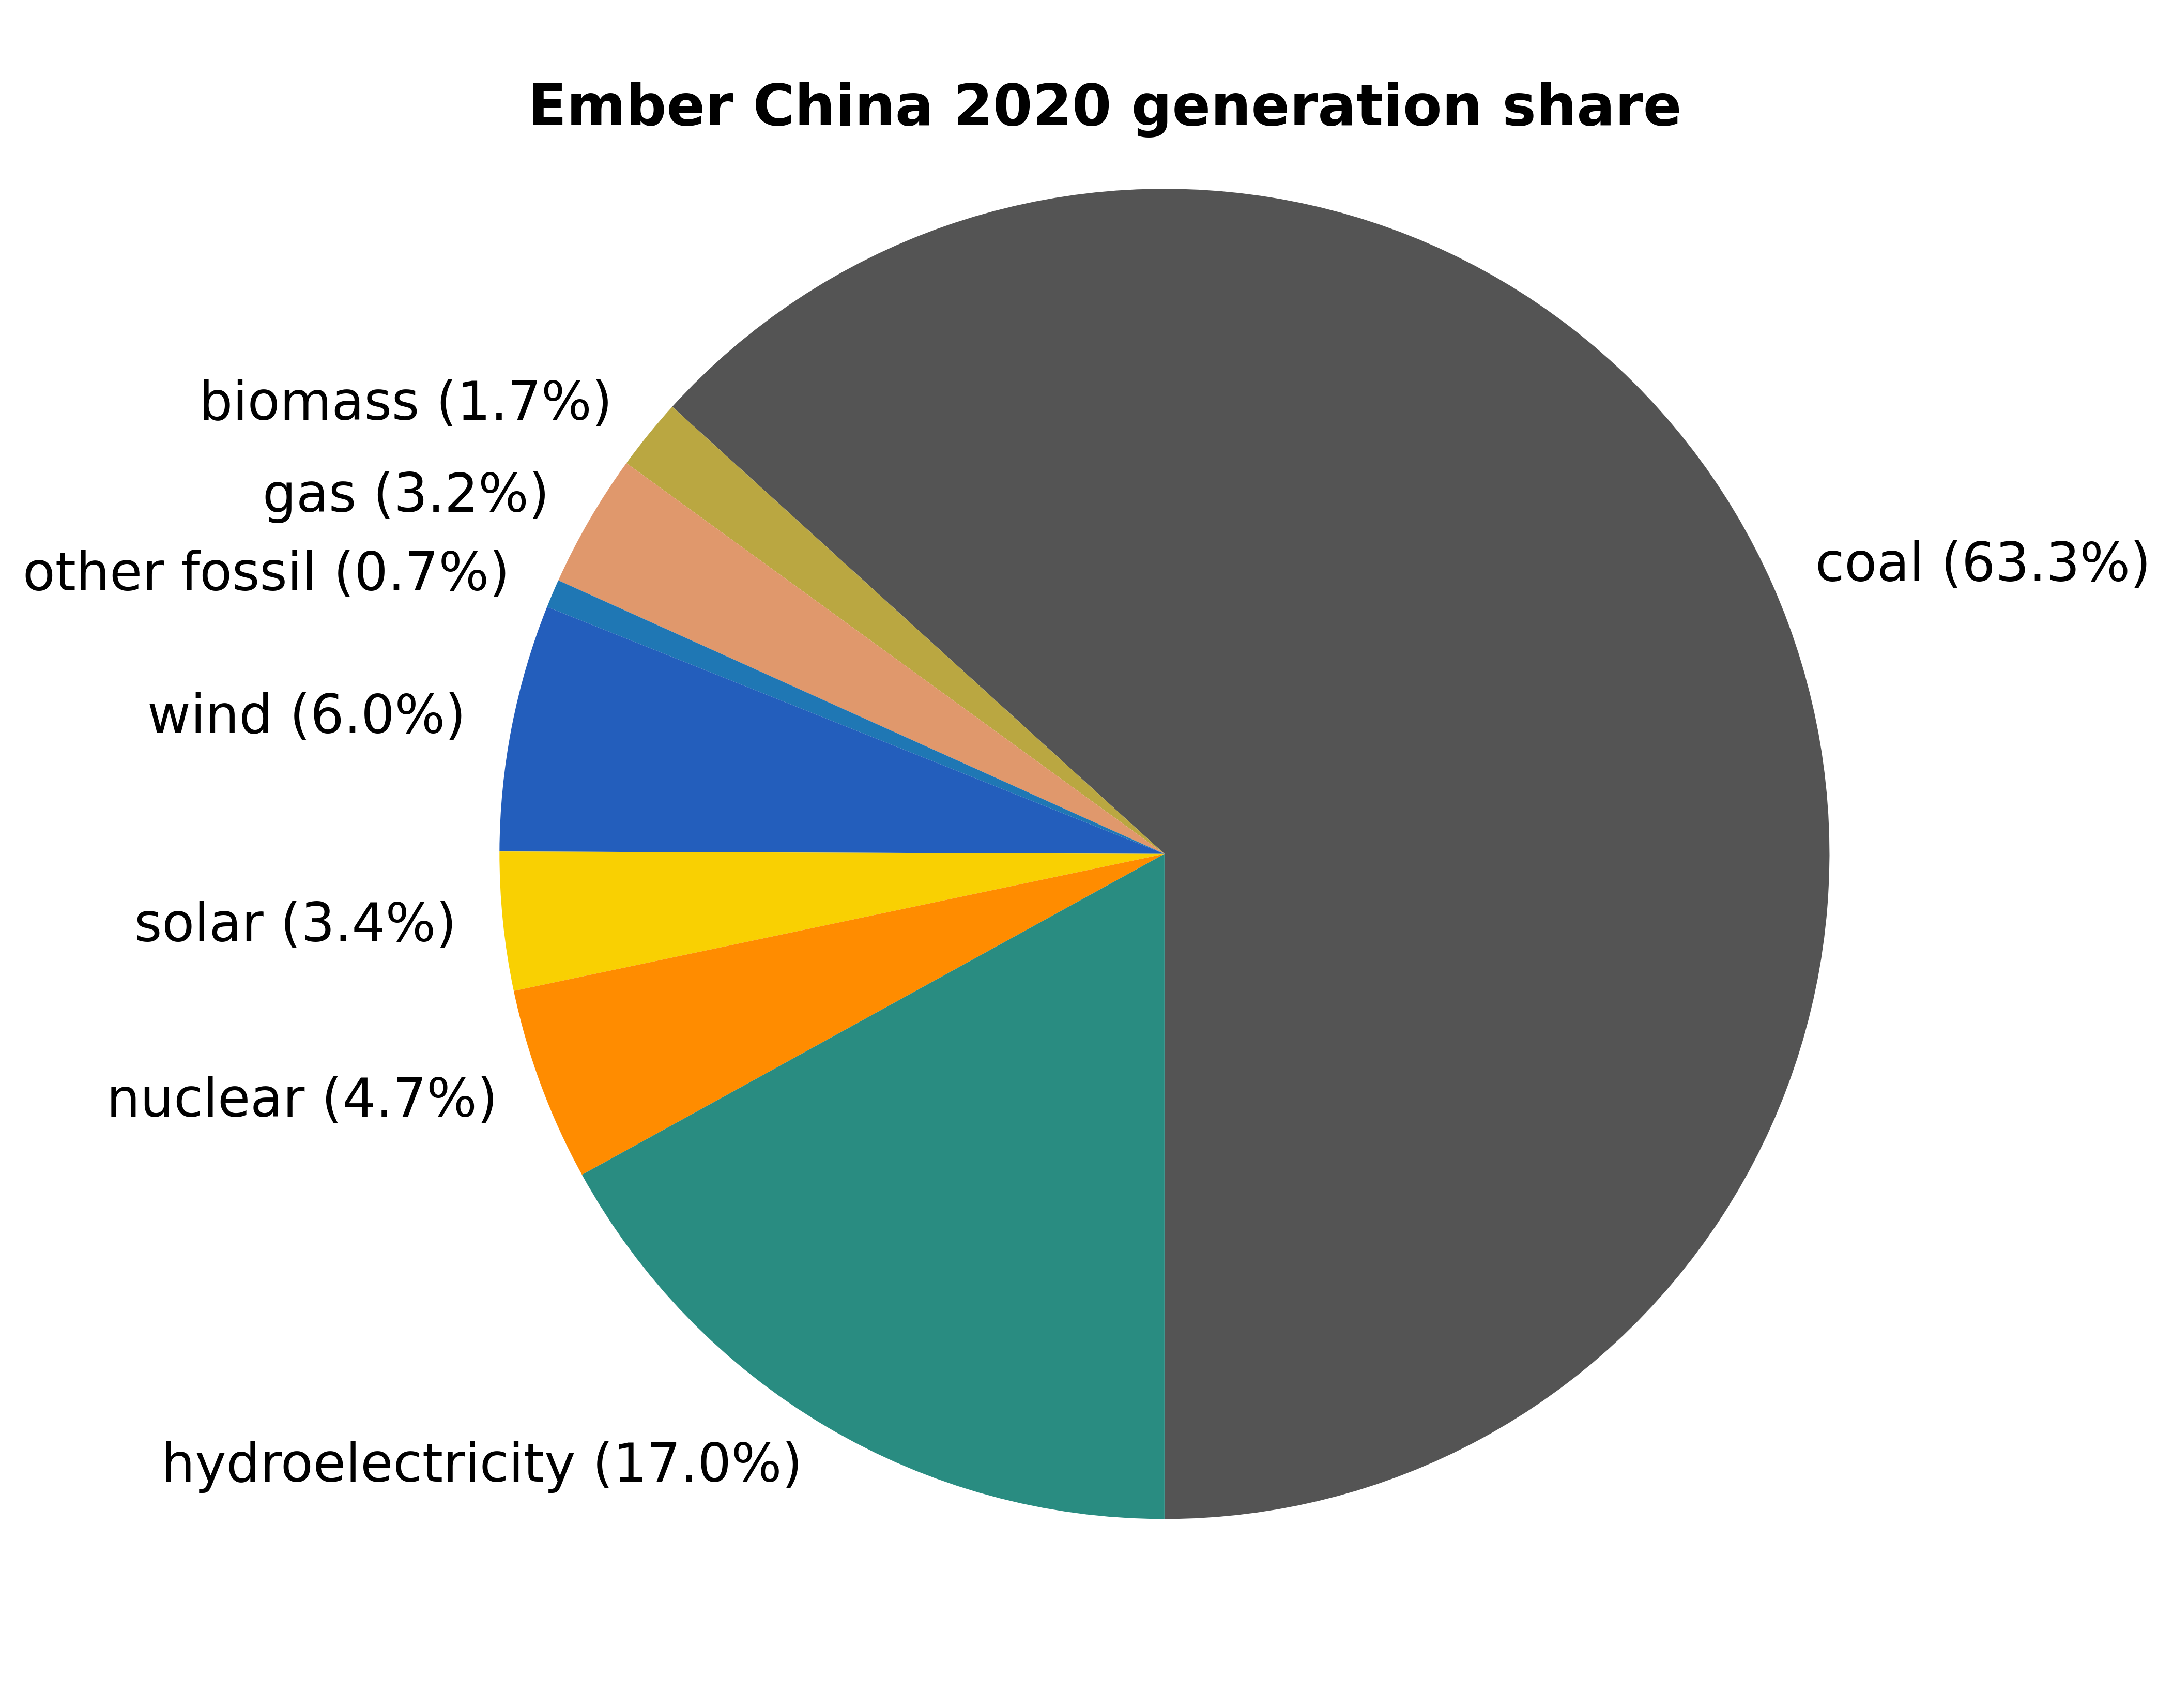

In [23]:
ax = ember_yr.share_of_generation_pct.clip(0).plot.pie(
    colors=colors_ember,
    figsize=(10, 8),
    labels=labels_ember,
    textprops={"fontsize": 16.8},
    legend=False,
    labeldistance=1.07,  # Move labels outward to reduce overlap
    startangle=270,
)
ax.set_ylabel("")
fig = ax.get_figure()
fig.suptitle(
    f"Ember China {year} generation share",
    fontsize=18,
    weight="580",
    fontname="sans-serif",
)
fig.tight_layout()
fig.suptitle(
    f"Ember China {year} generation share",
    fontsize=18,
    weight="580",
    fontname="sans-serif",
    y=0.9,
)
# fig.subplots_adjust(top=0.85)
fig.tight_layout()
fig.set_dpi(440);

In [24]:
CO2_EL_2020 = 4.716 * 1e9  # tCO2, Ember https://ember-energy.org/countries-and-regions/china/
CO2_EL_2025 = 5.65 * 1e9  # tCO2
CO2_EL_2025/CO2_EL_2020 

1.198049e+00

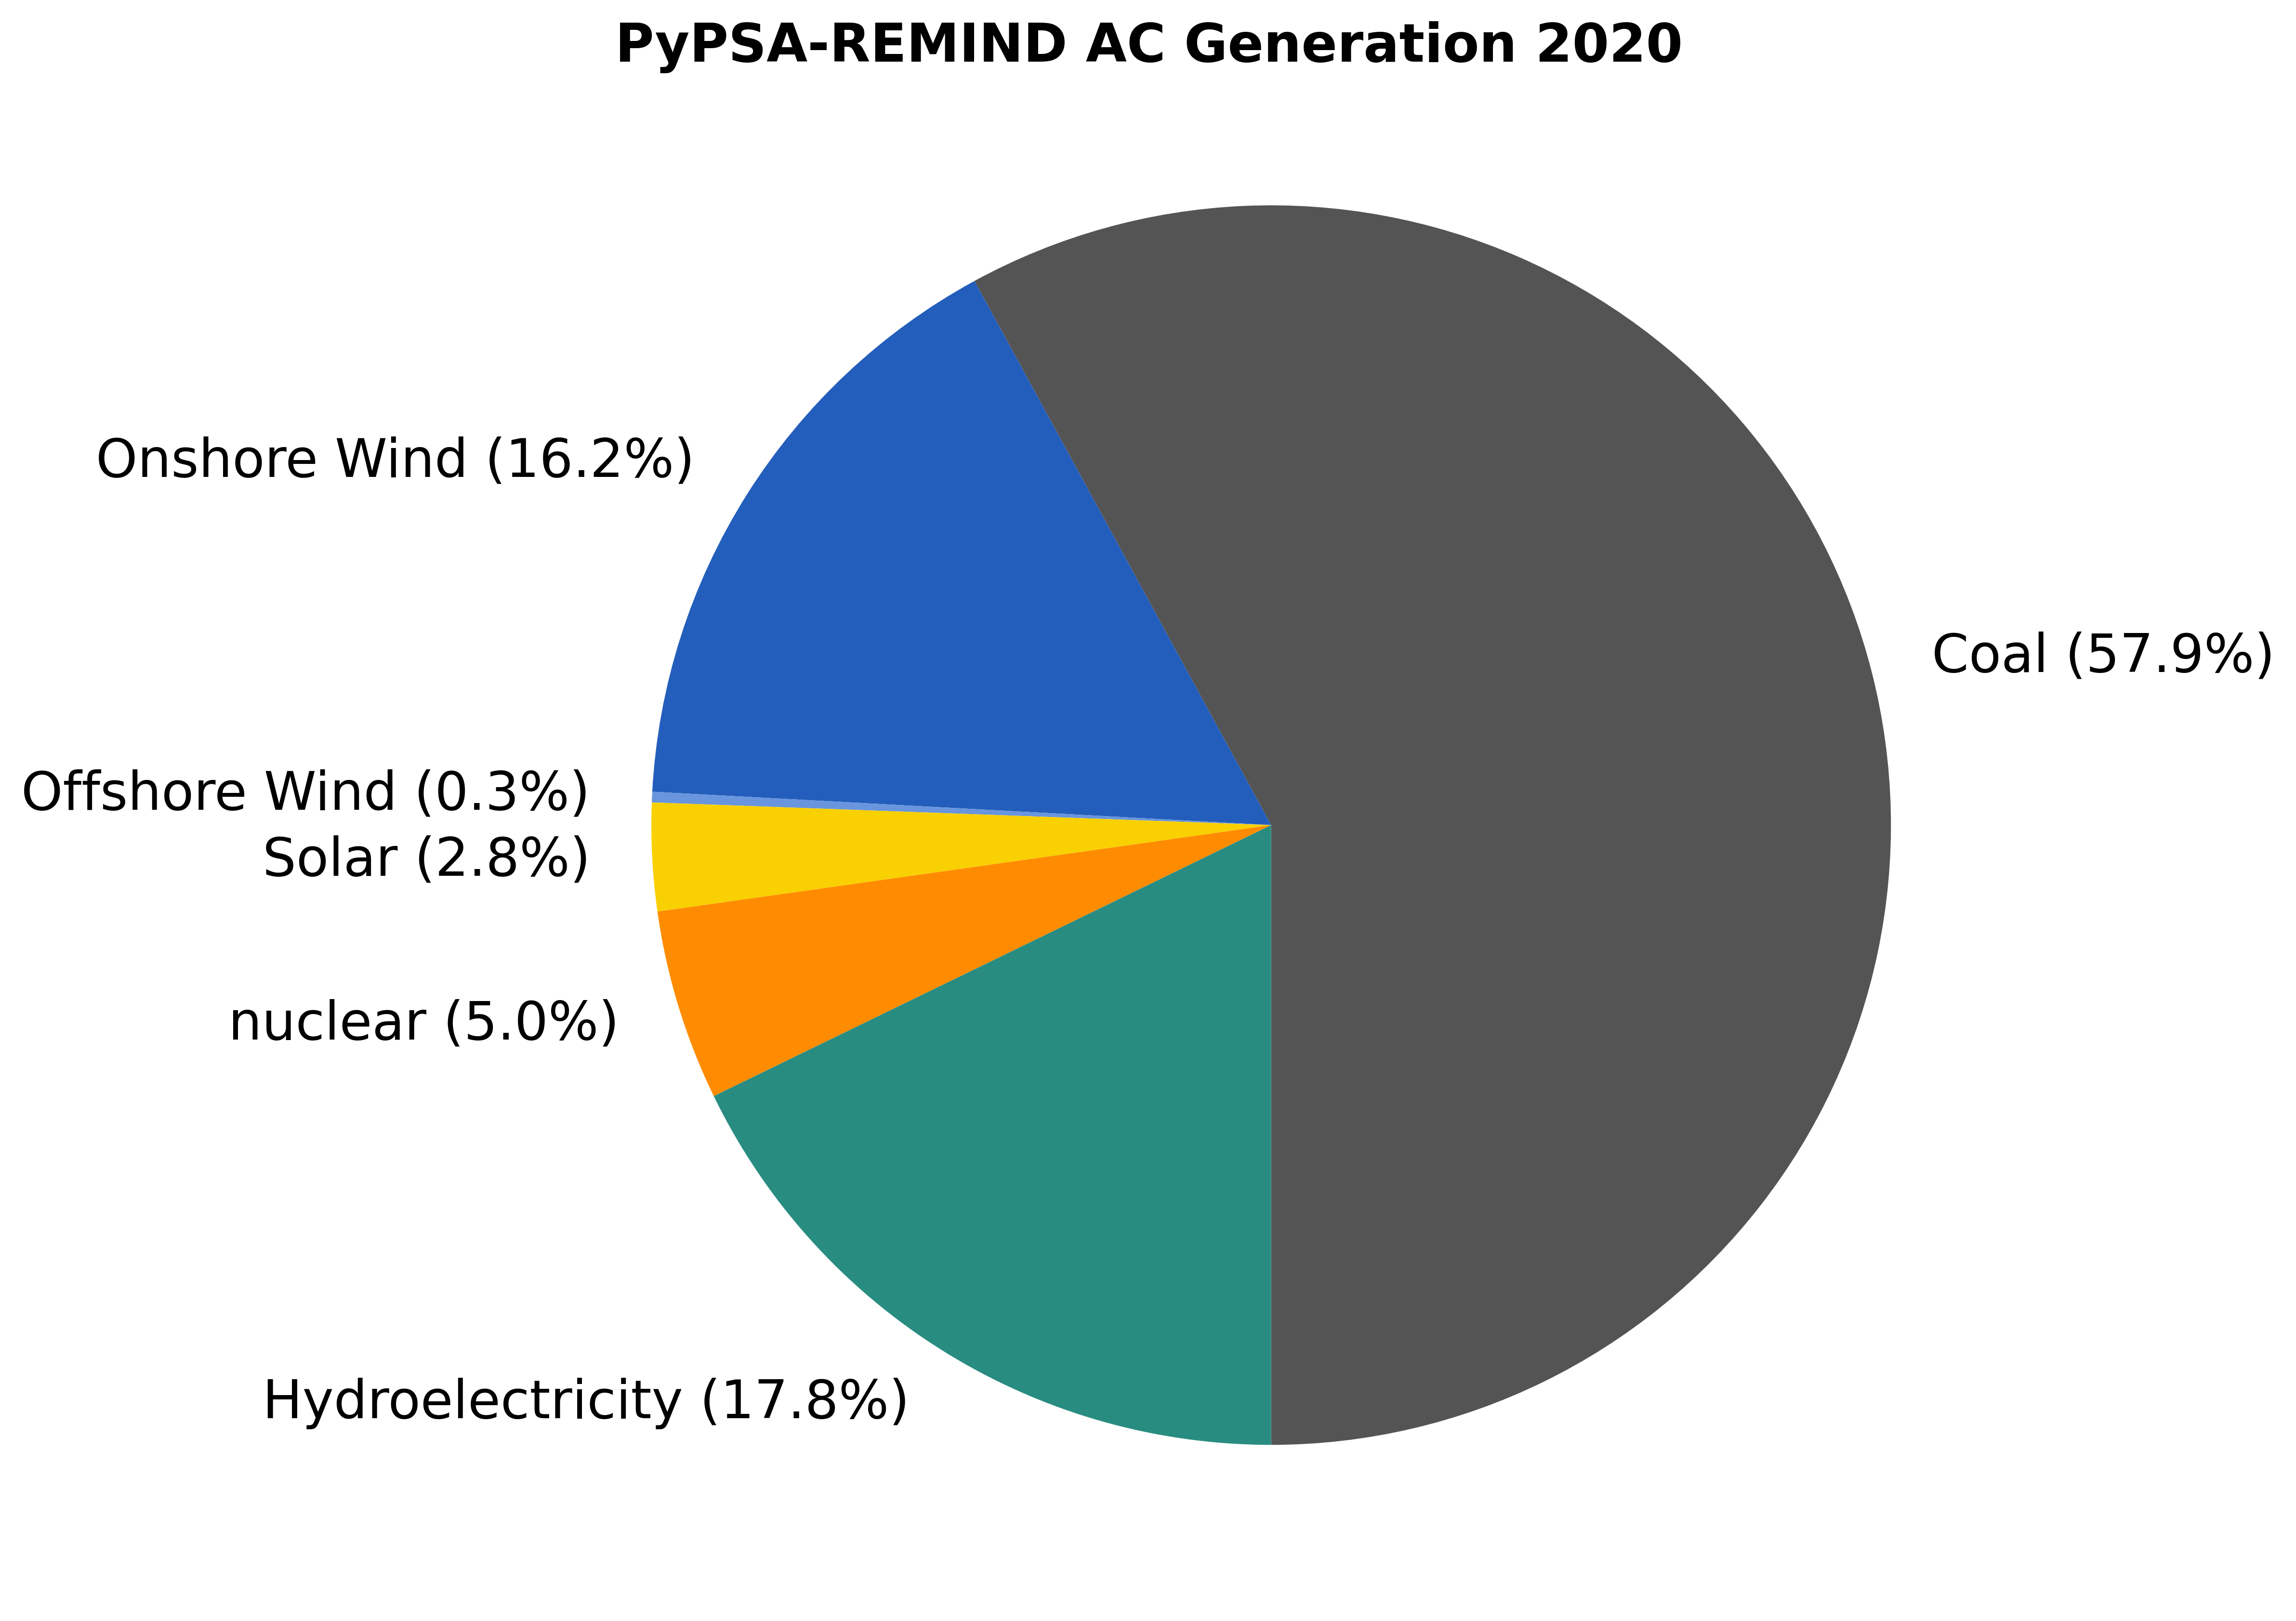

In [25]:
ax = ac_balance_mod.plot.pie(
    colors=colors,
    labels=labels,
    autopct=None,
    figsize=(10, 8),
    textprops={"fontsize": 18},
    startangle=270,
)
fig = ax.get_figure()
fig.suptitle(
    f"PyPSA-REMIND AC Generation {PLANNING_YEAR}",
    fontsize=18,
    weight="580",
    fontname="sans-serif",
    y=0.95,
)
fig.tight_layout()
fig.set_dpi(440);

In [26]:
n.loads_t.p_set.columns

Index(['Anhui', 'Anhui central heat', 'Anhui decentral heat', 'Beijing',
       'Beijing central heat', 'Beijing decentral heat', 'Chongqing',
       'Chongqing central heat', 'Chongqing decentral heat', 'Fujian',
       'Fujian central heat', 'Fujian decentral heat', 'Gansu',
       'Gansu central heat', 'Gansu decentral heat', 'Guangdong',
       'Guangdong central heat', 'Guangdong decentral heat', 'Guangxi',
       'Guangxi central heat', 'Guangxi decentral heat', 'Guizhou',
       'Guizhou central heat', 'Guizhou decentral heat', 'Hainan',
       'Hainan central heat', 'Hainan decentral heat', 'Hebei',
       'Hebei central heat', 'Hebei decentral heat', 'Heilongjiang',
       'Heilongjiang central heat', 'Heilongjiang decentral heat', 'Henan',
       'Henan central heat', 'Henan decentral heat', 'Hubei',
       'Hubei central heat', 'Hubei decentral heat', 'Hunan',
       'Hunan central heat', 'Hunan decentral heat', 'InnerMongolia',
       'InnerMongolia central heat', 'InnerMon

In [27]:
n.snapshot_weightings

,objective,stores,generators
snapshot,,,
2020-01-01 00:00:00,5.0,5.0,5.0
2020-01-01 05:00:00,5.0,5.0,5.0
2020-01-01 10:00:00,5.0,5.0,5.0
2020-01-01 15:00:00,5.0,5.0,5.0
2020-01-01 20:00:00,5.0,5.0,5.0
...,...,...,...
2020-12-30 23:00:00,5.0,5.0,5.0
2020-12-31 04:00:00,5.0,5.0,5.0
2020-12-31 09:00:00,5.0,5.0,5.0


In [28]:
df = n.statistics.withdrawal(comps=["Load"], groupby = "bus").reset_index()
df["carrier"] = df.bus.map(n.buses.carrier)
df.groupby("carrier").objective.sum()

carrier
AC      7.586342e+09
heat    3.605573e+09
Name: objective, dtype: float64

In [29]:
n.snapshot_weightings.objective[0]

/p/tmp/ivanra/anaconda/ipykernel_914201/374896978.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



5.000000e+00

In [30]:
n.loads_t.p_set.T.groupby(n.buses.carrier).sum().T.sum()*n.snapshot_weightings.objective[0]

/p/tmp/ivanra/anaconda/ipykernel_914201/3364888820.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



carrier
AC      7.586342e+09
heat    3.605573e+09
dtype: float64

In [31]:
df= n.loads_t.p_set
df[[c for c in df.columns if c.find("decentral")!=-1]].sum().sum(), df[[c for c in df.columns if c.find("decentral")==-1 and c.find("central")!=-1]].sum().sum()

(2.586241e+08, 4.624905e+08)

<Axes: xlabel='snapshot'>

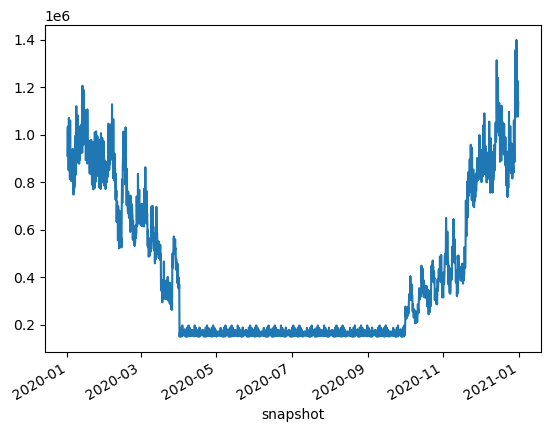

In [32]:
df[[c for c in df.columns if c.find("heat")!=-1]].T.sum().plot()